In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.window import Window

import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

In [2]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 50)

plt.style.use('seaborn-whitegrid')

#sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
#rcParams['figure.figsize'] = 18,4

In [4]:
# this allows plots to appear directly in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 18,4

In [6]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [7]:
# The following must be set in your .bashrc file
#SPARK_HOME="/home/ubuntu/spark-2.4.0-bin-hadoop2.7"
#ANACONDA_HOME="/home/ubuntu/anaconda3/envs/pyspark"
#PYSPARK_PYTHON="$ANACONDA_HOME/bin/python"
#PYSPARK_DRIVER_PYTHON="$ANACONDA_HOME/bin/python"
#PYTHONPATH="$ANACONDA_HOME/bin/python"
#export PATH="$ANACONDA_HOME/bin:$SPARK_HOME/bin:$PATH"

In [49]:
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("working-with-time-series-data")
         .getOrCreate())

In [50]:
spark

In [10]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=working-with-time-series-data>

In [11]:
ELECTRIC_POWER_CONSUMPTION = 'data/household_power_consumption.txt'

In [12]:
pow_consump_df = spark.read.csv(path=ELECTRIC_POWER_CONSUMPTION, sep=';', header=True, inferSchema=True)

In [13]:
pow_consump_df.count()

2075259

In [14]:
pow_consump_df.sample(withReplacement=False, fraction=0.000005, seed=rnd_seed).toPandas()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,14/1/2007,16:59:00,2.376,0.000,239.680,10.800,26.000,0.000,0.0
1,15/5/2007,05:24:00,0.268,0.050,237.200,1.200,0.000,0.000,0.0
2,3/8/2007,22:54:00,0.140,0.000,237.040,0.600,0.000,0.000,0.0
3,15/10/2007,23:42:00,0.330,0.054,242.510,1.400,0.000,0.000,0.0
4,14/6/2008,12:48:00,1.446,0.246,242.290,6.000,0.000,1.000,18.0
5,25/6/2008,10:44:00,0.242,0.000,236.900,1.200,0.000,0.000,0.0
6,19/1/2010,09:13:00,3.596,0.000,240.370,14.800,39.000,0.000,18.0
7,8/10/2010,06:07:00,0.500,0.280,239.130,2.400,0.000,2.000,0.0


In [15]:
pow_consump_df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Global_active_power: string (nullable = true)
 |-- Global_reactive_power: string (nullable = true)
 |-- Voltage: string (nullable = true)
 |-- Global_intensity: string (nullable = true)
 |-- Sub_metering_1: string (nullable = true)
 |-- Sub_metering_2: string (nullable = true)
 |-- Sub_metering_3: double (nullable = true)



We can see Spark was not able to identify the schema of Date and Time

In [16]:
# convert order_date into date format
pow_consump_df = pow_consump_df.withColumn('Date_Time', F.concat_ws(' ', 'Date', 'Time'))
pow_consump_df = pow_consump_df.withColumn('Date_Time', F.to_timestamp(col('Date_Time'), format='dd/MM/yyyy HH:mm:ss')).cache()
pow_consump_df.cache()

DataFrame[Date: string, Time: string, Global_active_power: string, Global_reactive_power: string, Voltage: string, Global_intensity: string, Sub_metering_1: string, Sub_metering_2: string, Sub_metering_3: double, Date_Time: timestamp]

In [17]:
pow_consump_df = (pow_consump_df
 .select('Date_Time', 
         F.dayofmonth('Date_Time').alias('Day'),
         F.month('Date_Time').alias('Month'), 
         F.year('Date_Time').alias('Year'), 
         F.hour('Date_Time').alias('Hour'), 
         F.weekofyear('Date_Time').alias('Week'),
         col('Global_active_power').cast(DoubleType()))
 .filter(col('Year').isin([2008, 2009])))
pow_consump_df.cache()

DataFrame[Date_Time: timestamp, Day: int, Month: int, Year: int, Hour: int, Week: int, Global_active_power: double]

In [18]:
pow_consump_df.show(10)

+-------------------+---+-----+----+----+----+-------------------+
|          Date_Time|Day|Month|Year|Hour|Week|Global_active_power|
+-------------------+---+-----+----+----+----+-------------------+
|2008-01-01 00:00:00|  1|    1|2008|   0|   1|               1.62|
|2008-01-01 00:01:00|  1|    1|2008|   0|   1|              1.626|
|2008-01-01 00:02:00|  1|    1|2008|   0|   1|              1.622|
|2008-01-01 00:03:00|  1|    1|2008|   0|   1|              1.612|
|2008-01-01 00:04:00|  1|    1|2008|   0|   1|              1.612|
|2008-01-01 00:05:00|  1|    1|2008|   0|   1|              1.546|
|2008-01-01 00:06:00|  1|    1|2008|   0|   1|              1.544|
|2008-01-01 00:07:00|  1|    1|2008|   0|   1|               1.55|
|2008-01-01 00:08:00|  1|    1|2008|   0|   1|              1.548|
|2008-01-01 00:09:00|  1|    1|2008|   0|   1|              1.548|
+-------------------+---+-----+----+----+----+-------------------+
only showing top 10 rows



In [19]:
pow_consump_df.printSchema()

root
 |-- Date_Time: timestamp (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Week: integer (nullable = true)
 |-- Global_active_power: double (nullable = true)



In [20]:
pow_consump_df.createOrReplaceTempView('pow_consump')

In [21]:
pdf = pow_consump_df.select('Hour', 'Month', 'Year', 'Global_active_power').sample(withReplacement=False, fraction=0.1, seed=rnd_seed).toPandas()

In [22]:
pdf.head()

,Hour,Month,Year,Global_active_power
0,0,1,2008,1.536
1,0,1,2008,1.646
2,0,1,2008,1.568
3,0,1,2008,1.568
4,1,1,2008,1.544


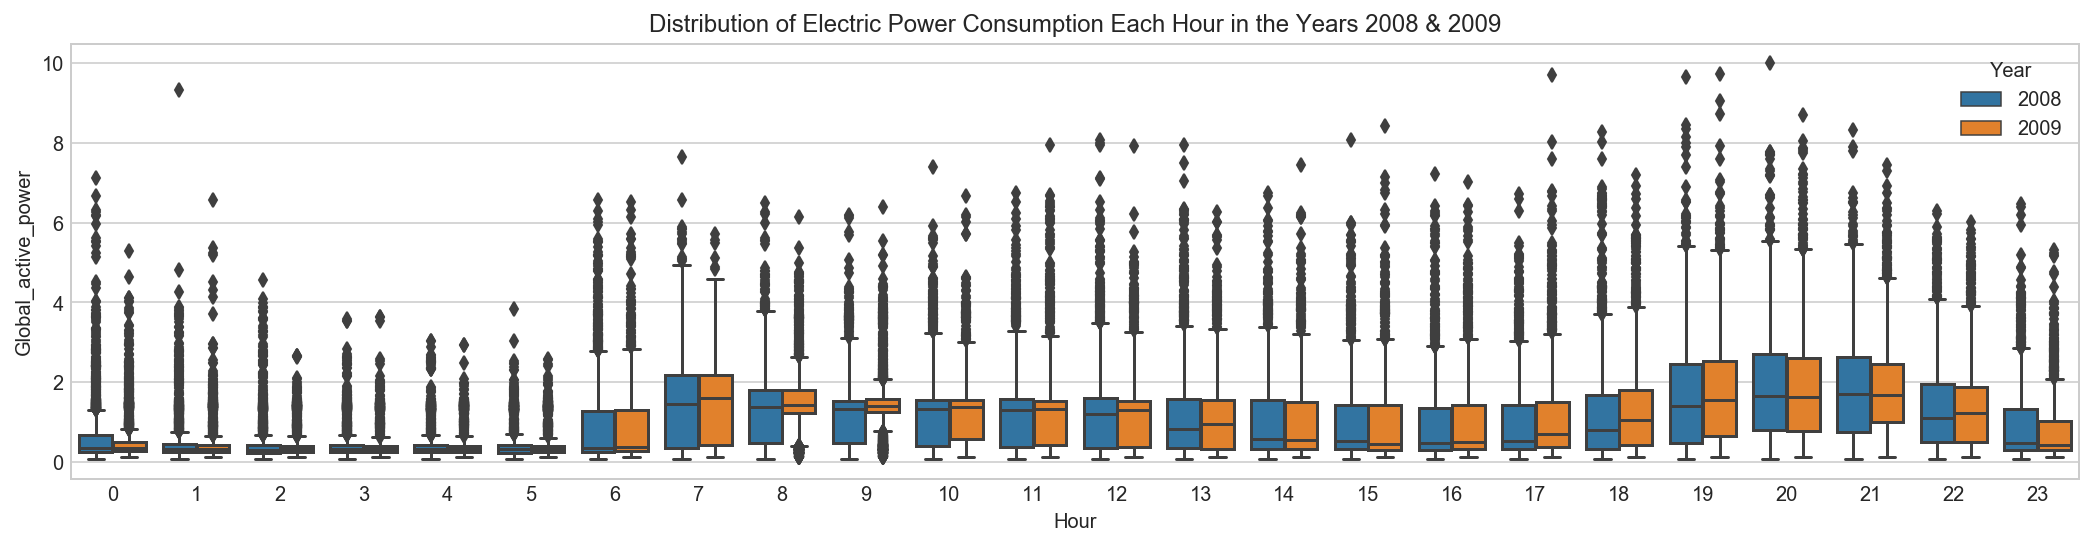

In [23]:
g = sns.boxplot(x='Hour', y='Global_active_power', hue='Year', data=pdf)
g.set_title('Distribution of Electric Power Consumption Each Hour in the Years 2008 & 2009');

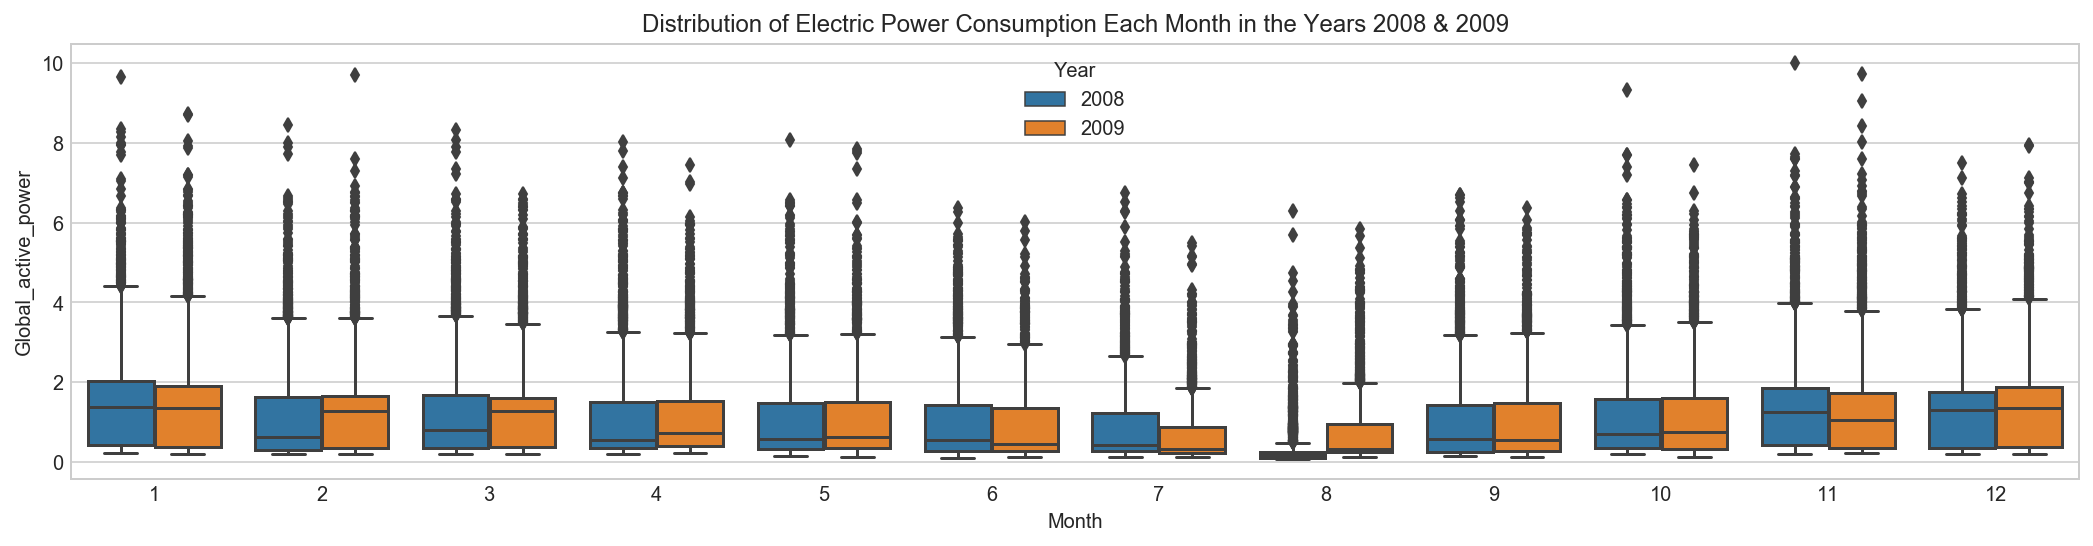

In [24]:
g = sns.boxplot(x='Month', y='Global_active_power', hue='Year', data=pdf)
g.set_title('Distribution of Electric Power Consumption Each Month in the Years 2008 & 2009');

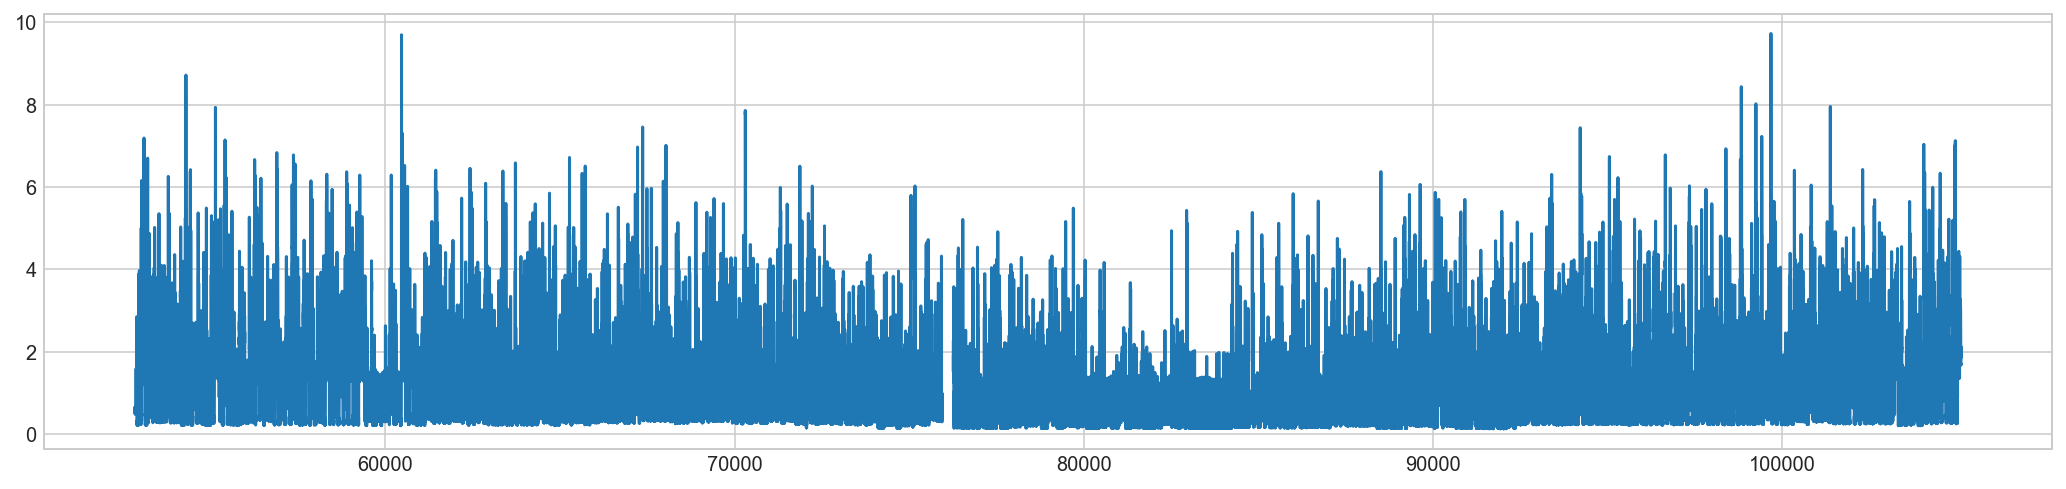

In [25]:
plt.plot(pdf[pdf['Year'] == 2009]['Global_active_power']);

In [26]:
spark.sql('select * from pow_consump').show(10)

+-------------------+---+-----+----+----+----+-------------------+
|          Date_Time|Day|Month|Year|Hour|Week|Global_active_power|
+-------------------+---+-----+----+----+----+-------------------+
|2008-01-01 00:00:00|  1|    1|2008|   0|   1|               1.62|
|2008-01-01 00:01:00|  1|    1|2008|   0|   1|              1.626|
|2008-01-01 00:02:00|  1|    1|2008|   0|   1|              1.622|
|2008-01-01 00:03:00|  1|    1|2008|   0|   1|              1.612|
|2008-01-01 00:04:00|  1|    1|2008|   0|   1|              1.612|
|2008-01-01 00:05:00|  1|    1|2008|   0|   1|              1.546|
|2008-01-01 00:06:00|  1|    1|2008|   0|   1|              1.544|
|2008-01-01 00:07:00|  1|    1|2008|   0|   1|               1.55|
|2008-01-01 00:08:00|  1|    1|2008|   0|   1|              1.548|
|2008-01-01 00:09:00|  1|    1|2008|   0|   1|              1.548|
+-------------------+---+-----+----+----+----+-------------------+
only showing top 10 rows



In [27]:
spark.sql('select * from pow_consump where Month = 7 and Year = 2009').show(10)

+-------------------+---+-----+----+----+----+-------------------+
|          Date_Time|Day|Month|Year|Hour|Week|Global_active_power|
+-------------------+---+-----+----+----+----+-------------------+
|2009-07-01 00:00:00|  1|    7|2009|   0|  27|              0.194|
|2009-07-01 00:01:00|  1|    7|2009|   0|  27|              0.194|
|2009-07-01 00:02:00|  1|    7|2009|   0|  27|              0.196|
|2009-07-01 00:03:00|  1|    7|2009|   0|  27|              0.194|
|2009-07-01 00:04:00|  1|    7|2009|   0|  27|              0.194|
|2009-07-01 00:05:00|  1|    7|2009|   0|  27|              0.194|
|2009-07-01 00:06:00|  1|    7|2009|   0|  27|              0.258|
|2009-07-01 00:07:00|  1|    7|2009|   0|  27|              0.272|
|2009-07-01 00:08:00|  1|    7|2009|   0|  27|              0.272|
|2009-07-01 00:09:00|  1|    7|2009|   0|  27|              0.272|
+-------------------+---+-----+----+----+----+-------------------+
only showing top 10 rows



In [28]:
spark.sql('select * from pow_consump where Month = 7 and Year = 2009 and Day = 31').count()

1440

In [29]:
60*24

1440

In [30]:
spark.sql('select * from pow_consump where Month = 7 and Year = 2009').count()

44640

In [31]:
31 * 24 * 60 # 31 days x 24 ours x 60 minutes

44640

### Resample:

In [32]:
# Monthly resample
monthly_resampled = spark.sql(
"""
select to_date(concat_ws('-', lpad(Month, 2, '0'), '01', Year), 'MM-dd-yyyy') as resampled_month, 
Month, Year,
ROUND(AVG(Global_active_power), 2) as avg_consumption, 
ROUND(MAX(Global_active_power), 2) as max_consumption, 
ROUND(MIN(Global_active_power), 2) as min_consumption 
FROM pow_consump 
WHERE Year in (2009)
GROUP BY month, year 
ORDER BY month, year
""")

monthly_resampled.cache()

DataFrame[resampled_month: date, Month: int, Year: int, avg_consumption: double, max_consumption: double, min_consumption: double]

In [33]:
monthly_resampled.show(12)

+---------------+-----+----+---------------+---------------+---------------+
|resampled_month|Month|Year|avg_consumption|max_consumption|min_consumption|
+---------------+-----+----+---------------+---------------+---------------+
|     2009-01-01|    1|2009|           1.41|           9.59|            0.2|
|     2009-02-01|    2|2009|           1.25|          11.12|            0.2|
|     2009-03-01|    3|2009|           1.23|           8.31|            0.2|
|     2009-04-01|    4|2009|           1.14|           7.97|           0.21|
|     2009-05-01|    5|2009|           1.01|           7.86|           0.14|
|     2009-06-01|    6|2009|           0.84|           8.76|           0.13|
|     2009-07-01|    7|2009|           0.62|           5.93|           0.12|
|     2009-08-01|    8|2009|           0.66|            7.7|           0.13|
|     2009-09-01|    9|2009|           0.99|           7.83|           0.12|
|     2009-10-01|   10|2009|           1.14|           8.71|           0.12|

In [34]:
pdf = monthly_resampled.select('resampled_month', 'avg_consumption').toPandas()

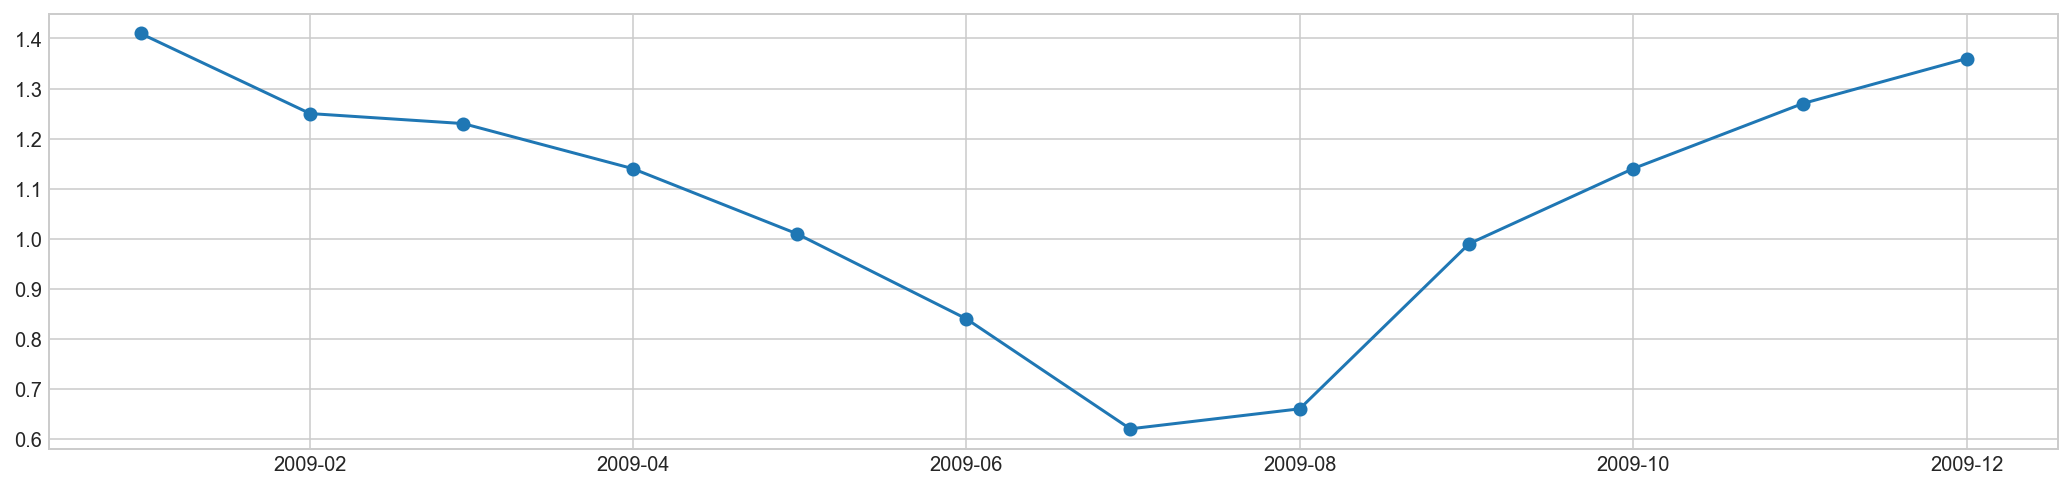

In [35]:
plt.plot_date(pdf['resampled_month'], pdf['avg_consumption'], linestyle='-');

In [36]:
# Daily resample
daily_resampled_df = spark.sql(
"""
select to_date(concat_ws('-', lpad(Month, 2, '0'), lpad(Day, 2, '0'), Year), 'MM-dd-yyyy') as resampled_day, 
Day, Month, Year,
ROUND(AVG(Global_active_power), 2) as avg_consumption, 
ROUND(MAX(Global_active_power), 2) max_consumption, 
ROUND(MIN(Global_active_power), 2) min_consumption 
FROM pow_consump 
WHERE Year in (2008, 2009) 
GROUP BY day, month, year 
ORDER BY day, month, year
""")
daily_resampled_df.cache()

DataFrame[resampled_day: date, Day: int, Month: int, Year: int, avg_consumption: double, max_consumption: double, min_consumption: double]

In [37]:
daily_resampled_df.createOrReplaceTempView('daily_resampled')

In [38]:
daily_resampled_df.show(10)

+-------------+---+-----+----+---------------+---------------+---------------+
|resampled_day|Day|Month|Year|avg_consumption|max_consumption|min_consumption|
+-------------+---+-----+----+---------------+---------------+---------------+
|   2008-01-01|  1|    1|2008|           1.92|           5.69|           0.23|
|   2009-01-01|  1|    1|2009|           0.98|           8.58|            0.2|
|   2008-02-01|  1|    2|2008|           1.07|           6.56|           0.21|
|   2009-02-01|  1|    2|2009|           1.29|           6.56|           0.21|
|   2008-03-01|  1|    3|2008|           0.79|           4.04|           0.48|
|   2009-03-01|  1|    3|2009|           1.71|           6.71|           0.26|
|   2008-04-01|  1|    4|2008|           1.48|           6.32|           0.23|
|   2009-04-01|  1|    4|2009|           1.14|           4.23|           0.21|
|   2008-05-01|  1|    5|2008|            0.4|            1.5|           0.24|
|   2009-05-01|  1|    5|2009|           1.05|      

In [39]:
daily_resampled_df.printSchema()

root
 |-- resampled_day: date (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- avg_consumption: double (nullable = true)
 |-- max_consumption: double (nullable = true)
 |-- min_consumption: double (nullable = true)



In [40]:
pdf = daily_resampled_df.toPandas()

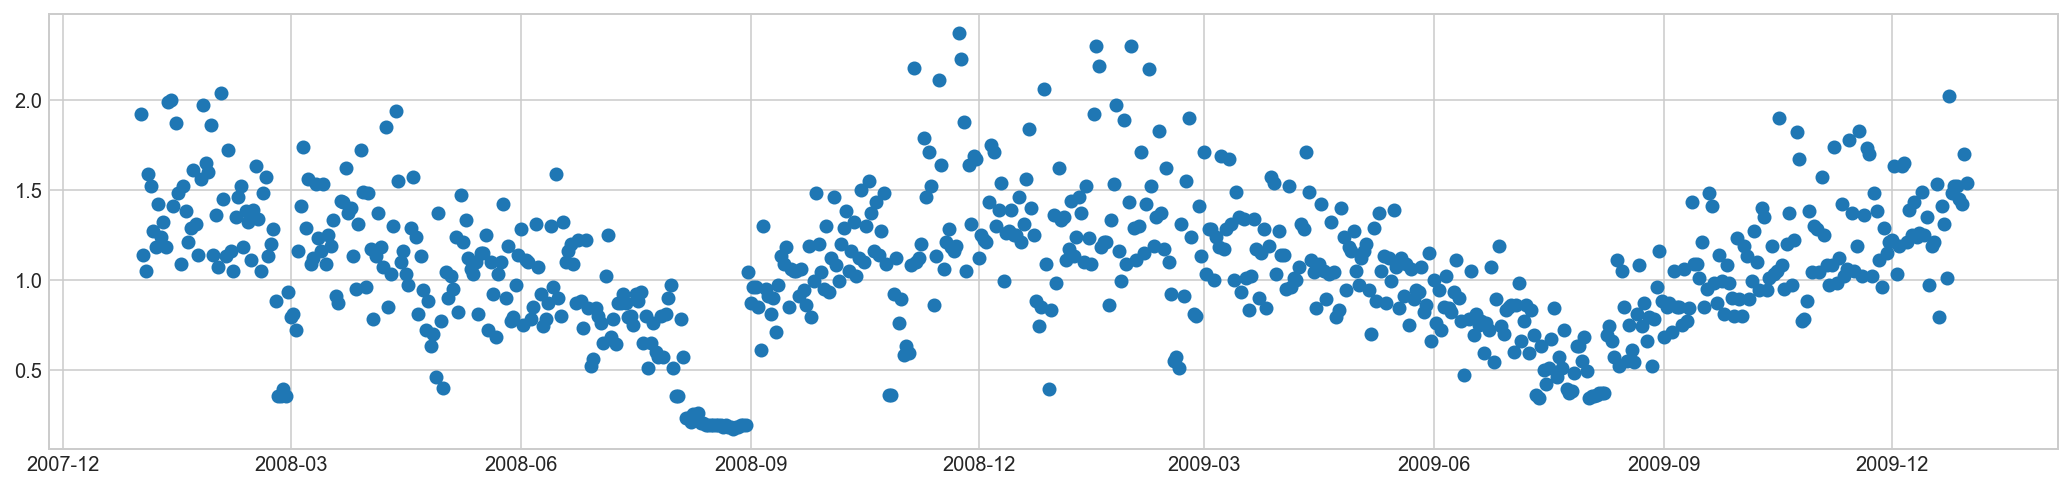

In [41]:
plt.plot_date(pdf['resampled_day'], pdf['avg_consumption']);

### 7 Days Moving Average:

In [42]:
daily_resampled_df = spark.sql(
"""
SELECT resampled_day, Day, Month, Year, avg_consumption, 
ROUND(AVG(avg_consumption) OVER (PARTITION BY Year, Month ORDER BY Day ROWS BETWEEN 7 PRECEDING AND CURRENT ROW), 2) AS moving_avg,
ROUND(stddev(avg_consumption) OVER (PARTITION BY Year, Month ORDER BY Day ROWS BETWEEN 7 PRECEDING AND CURRENT ROW), 2) AS std_dev
FROM daily_resampled
ORDER BY Year, Month, Day
""")

daily_resampled_df.cache()

DataFrame[resampled_day: date, Day: int, Month: int, Year: int, avg_consumption: double, moving_avg: double, std_dev: double]

In [43]:
daily_resampled_df

DataFrame[resampled_day: date, Day: int, Month: int, Year: int, avg_consumption: double, moving_avg: double, std_dev: double]

In [44]:
daily_resampled_df.show()

+-------------+---+-----+----+---------------+----------+-------+
|resampled_day|Day|Month|Year|avg_consumption|moving_avg|std_dev|
+-------------+---+-----+----+---------------+----------+-------+
|   2008-01-01|  1|    1|2008|           1.92|      1.92|    NaN|
|   2008-01-02|  2|    1|2008|           1.14|      1.53|   0.55|
|   2008-01-03|  3|    1|2008|           1.05|      1.37|   0.48|
|   2008-01-04|  4|    1|2008|           1.59|      1.42|   0.41|
|   2008-01-05|  5|    1|2008|           1.52|      1.44|   0.35|
|   2008-01-06|  6|    1|2008|           1.27|      1.41|   0.32|
|   2008-01-07|  7|    1|2008|           1.18|      1.38|   0.31|
|   2008-01-08|  8|    1|2008|           1.42|      1.39|   0.29|
|   2008-01-09|  9|    1|2008|           1.24|       1.3|   0.19|
|   2008-01-10| 10|    1|2008|           1.32|      1.32|   0.18|
|   2008-01-11| 11|    1|2008|           1.18|      1.34|   0.15|
|   2008-01-12| 12|    1|2008|           1.99|      1.39|   0.27|
|   2008-0

In [45]:
pdf = daily_resampled_df.toPandas()

In [46]:
pdf.set_index('resampled_day', inplace=True)

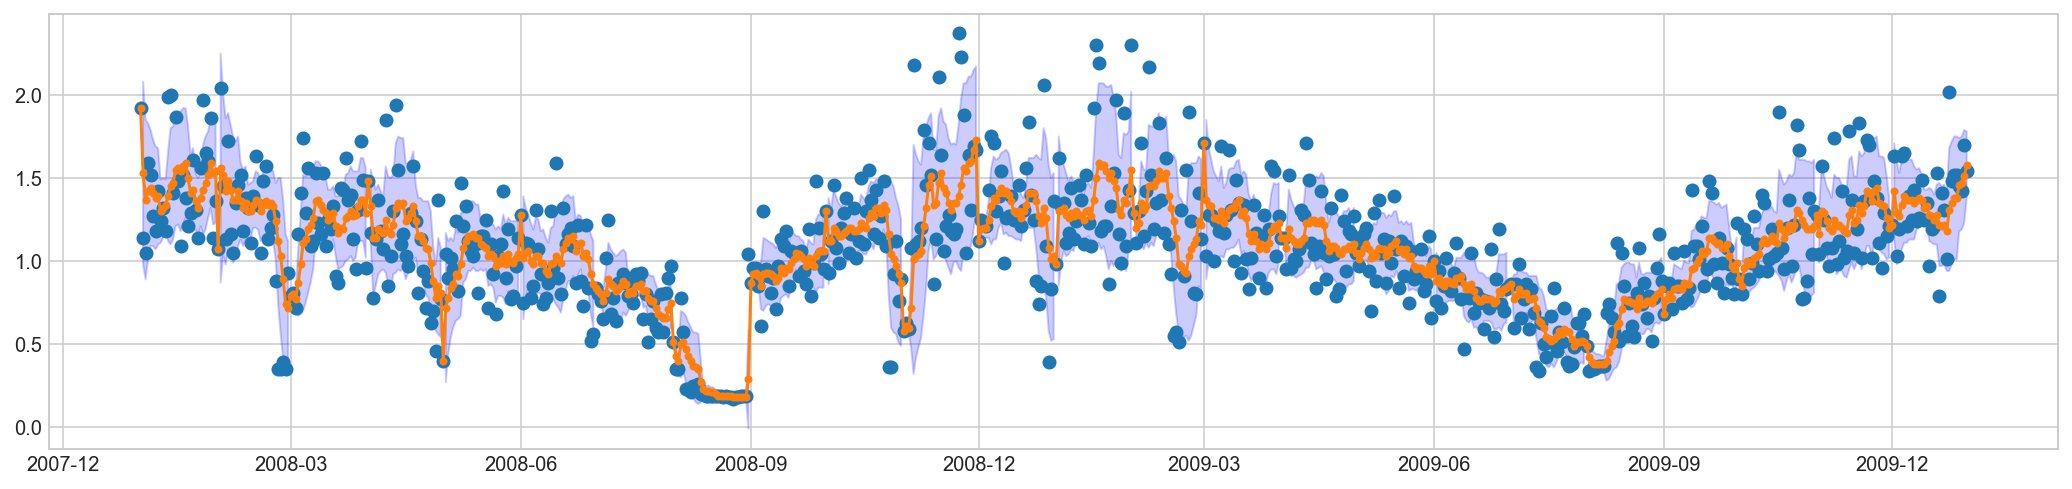

In [47]:
plt.plot_date(pdf.index, pdf['avg_consumption'])
plt.plot_date(pdf.index, pdf['moving_avg'], linestyle='-', marker='.')
plt.fill_between(pdf.index, pdf['moving_avg'] - 1 * pdf['std_dev'], pdf['moving_avg'] + 1 * pdf['std_dev'], color='b', alpha = 0.2);

## Sessionization of a Clickstream
`Sessionization` can be explained as the process of dividing a clickstream into sessions based on key-based partitioning, and within that subdividing based on click frequency. For example, one frequently used mechanism is to consider two clicks from a particular IP address that take place more than 30 minutes apart as being different sessions.

Users' click stream data https://www.kaggle.com/retailrocket/ecommerce-dataset

In [144]:
RETAILROCKET_CLICKSTREAM = 'data/retailrocket-recommender-system-dataset/events.csv'

In [145]:
user_events = spark.read.csv(path=RETAILROCKET_CLICKSTREAM, header=True, inferSchema=True)

In [146]:
user_events.count()

2756101

In [147]:
user_events.sample(withReplacement=False, fraction=0.000005, seed=rnd_seed).limit(10).show()

+-------------+---------+-----+------+-------------+
|    timestamp|visitorid|event|itemid|transactionid|
+-------------+---------+-----+------+-------------+
|1433270143882|   111658| view|109616|         null|
|1433999574695|  1093974| view|418366|         null|
|1434874420982|   193328| view|447074|         null|
|1435466475091|    15149| view|390098|         null|
|1440219866779|  1023568| view| 38404|         null|
|1440706319925|   635259| view|188390|         null|
|1442297965843|  1056782| view|304246|         null|
|1436047155194|  1164077| view|297721|         null|
|1436323207355|   269503| view|142466|         null|
|1438038026270|   721937| view|  5510|         null|
+-------------+---------+-----+------+-------------+



In [148]:
user_events.printSchema()

root
 |-- timestamp: long (nullable = true)
 |-- visitorid: integer (nullable = true)
 |-- event: string (nullable = true)
 |-- itemid: integer (nullable = true)
 |-- transactionid: integer (nullable = true)



It looks like that the timestamp is reeported in milliseconds  
1428476400  
1433221332117

### User Events:

In [149]:
user_events = user_events.withColumn('event_time', F.from_unixtime(col('timestamp') / 1000, format='yyyy-MM-dd HH:mm:ss'))

In [150]:
user_events.printSchema()

root
 |-- timestamp: long (nullable = true)
 |-- visitorid: integer (nullable = true)
 |-- event: string (nullable = true)
 |-- itemid: integer (nullable = true)
 |-- transactionid: integer (nullable = true)
 |-- event_time: string (nullable = true)



In [ ]:
user_events = user_events.select('timestamp', 'event_time', 'visitorid', 'event', 'itemid', 'transactionid')

In [151]:
user_events.cache().createOrReplaceTempView('user_events')

DataFrame[timestamp: bigint, event_time: string, visitorid: int, event: string, itemid: int, transactionid: int]

In [153]:
user_events.limit(10).show()

+-------------+-------------------+---------+-----+------+-------------+
|    timestamp|         event_time|visitorid|event|itemid|transactionid|
+-------------+-------------------+---------+-----+------+-------------+
|1433221332117|2015-06-01 22:02:12|   257597| view|355908|         null|
|1433224214164|2015-06-01 22:50:14|   992329| view|248676|         null|
|1433221999827|2015-06-01 22:13:19|   111016| view|318965|         null|
|1433221955914|2015-06-01 22:12:35|   483717| view|253185|         null|
|1433221337106|2015-06-01 22:02:17|   951259| view|367447|         null|
|1433224086234|2015-06-01 22:48:06|   972639| view| 22556|         null|
|1433221923240|2015-06-01 22:12:03|   810725| view|443030|         null|
|1433223291897|2015-06-01 22:34:51|   794181| view|439202|         null|
|1433220899221|2015-06-01 21:54:59|   824915| view|428805|         null|
|1433221204592|2015-06-01 22:00:04|   339335| view| 82389|         null|
+-------------+-------------------+---------+-----+

What makes this interesting is that the dependency on a session is defined based on the difference between the current timestamp and the previous timestamp, which we can calculate easily using the lag() window function:

In [154]:
spark.sql(
"""
SELECT
    timestamp,
    visitorid,
    FROM_UNIXTIME(LAG(timestamp, 1) OVER (PARTITION BY visitorid ORDER BY timestamp) / 1000, 'yyyy-MM-dd HH:mm:ss') as prev_event_time,
    ROUND((timestamp - LAG(timestamp, 1) OVER (PARTITION BY visitorid ORDER BY timestamp)) / (1000 * 60), 2) as inactivity_time
FROM user_events
ORDER BY visitorid, timestamp
""").show()

+-------------+---------+-------------------+---------------+
|    timestamp|visitorid|    prev_event_time|inactivity_time|
+-------------+---------+-------------------+---------------+
|1442004589439|        0|               null|           null|
|1442004759591|        0|2015-09-11 13:49:49|           2.84|
|1442004917175|        0|2015-09-11 13:52:39|           2.63|
|1439487966444|        1|               null|           null|
|1438969904567|        2|               null|           null|
|1438970013790|        2|2015-08-07 10:51:44|           1.82|
|1438970212664|        2|2015-08-07 10:53:33|           3.31|
|1438970468920|        2|2015-08-07 10:56:52|           4.27|
|1438970905669|        2|2015-08-07 11:01:08|           7.28|
|1438971444375|        2|2015-08-07 11:08:25|           8.98|
|1438971463170|        2|2015-08-07 11:17:24|           0.31|
|1438971657845|        2|2015-08-07 11:17:43|           3.24|
|1438413035296|        3|               null|           null|
|1442352

This gets us partway, but only gives us an indication of when a new session begins. To complete the problem, we need a distinct session number to be generated. This can be done with one extra pass over the result, to add up the new session events as an accumulated sum:

### User Sessions:

In [159]:
spark.sql("""
SELECT 
    CONCAT_WS('-', e.visitorid, ROW_NUMBER() OVER (PARTITION BY visitorid ORDER BY timestamp)) as session_id,
    e.visitorid,
    e.event_time as session_start_at,
    LEAD(e.event_time) OVER (PARTITION BY e.visitorid ORDER BY e.timestamp) as next_session_start_at
FROM (SELECT 
        visitorid, 
        timestamp,
        event_time, 
        ROUND((timestamp - LAG(timestamp, 1) OVER (PARTITION BY visitorid ORDER BY timestamp)) / (1000 * 60), 2) as inactivity_time
      FROM user_events)  e
WHERE (e.inactivity_time > 30 or e.inactivity_time is null)
ORDER BY e.visitorid, session_start_at
"""
).cache().createOrReplaceTempView('user_sessions')

In [162]:
spark.sql("SELECT * FROM user_sessions").show(10)

+----------+---------+-------------------+---------------------+
|session_id|visitorid|   session_start_at|next_session_start_at|
+----------+---------+-------------------+---------------------+
|       0-1|        0|2015-09-11 13:49:49|                 null|
|       1-1|        1|2015-08-13 10:46:06|                 null|
|       2-1|        2|2015-08-07 10:51:44|                 null|
|       3-1|        3|2015-08-01 00:10:35|                 null|
|       4-1|        4|2015-09-15 14:24:27|                 null|
|       5-1|        5|2015-07-16 18:45:56|                 null|
|       6-1|        6|2015-08-29 23:03:48|  2015-08-29 23:39:38|
|       6-2|        6|2015-08-29 23:39:38|  2015-08-30 20:21:25|
|       6-3|        6|2015-08-30 20:21:25|                 null|
|       7-1|        7|2015-05-13 22:39:36|  2015-05-15 21:20:39|
+----------+---------+-------------------+---------------------+
only showing top 10 rows



### Session Statistics:

In [176]:
spark.sql(
"""
SELECT 
    user_sessions.session_id, split(user_sessions.session_id, '-')[1] as visitorid,
    CASE WHEN (max(user_events.timestamp) != min(user_events.timestamp)) THEN ROUND(((max(user_events.timestamp) - min(user_events.timestamp)) / (1000 * 60)), 2) ELSE 15 END as duration
    FROM user_sessions
        LEFT JOIN user_events ON user_events.visitorid = user_sessions.visitorid
    AND user_events.event_time >= user_sessions.session_start_at
    AND (user_events.event_time < user_sessions.next_session_start_at or user_sessions.next_session_start_at is null)
    GROUP BY user_sessions.session_id
""").show()

+----------+---------+--------+
|session_id|visitorid|duration|
+----------+---------+--------+
|   52133-1|        1|    15.0|
|   15004-1|        1|    15.0|
|  684168-1|        1|   21.58|
|   49308-1|        1|    15.0|
|  756637-1|        1|    15.0|
|  119517-1|        1|    15.0|
|  797405-1|        1|    15.0|
|  193733-1|        1|    15.0|
|  961070-1|        1|    15.0|
|  296738-1|        1|    15.0|
| 1041322-1|        1|    15.0|
|  311710-1|        1|    15.0|
| 1118856-1|        1|    3.86|
|  583497-1|        1|     3.9|
| 1170890-1|        1|    28.4|
|  651566-1|        1|    15.0|
|  682561-1|        1|    15.0|
|   26583-1|        1|    15.0|
|   99454-1|        1|    15.0|
| 1247803-1|        1|    15.0|
+----------+---------+--------+
only showing top 20 rows



### Item Statistics:

In [179]:
spark.sql(
"""
SELECT 
    user_sessions.session_id, split(user_sessions.session_id, '-')[1] as visitorid, user_events.event, COUNT(user_events.event)
    FROM user_sessions
        LEFT JOIN user_events ON user_events.visitorid = user_sessions.visitorid
    AND user_events.event_time >= user_sessions.session_start_at
    AND (user_events.event_time < user_sessions.next_session_start_at or user_sessions.next_session_start_at is null)
    GROUP BY user_sessions.session_id, user_events.event
""").show()

+----------+---------+-----+------------+
|session_id|visitorid|event|count(event)|
+----------+---------+-----+------------+
|       0-1|        1| view|           3|
|       1-1|        1| view|           1|
|      10-1|        1| view|           1|
|     100-1|        1| view|           4|
|    1000-1|        1| view|           1|
|   10000-1|        1| view|           6|
|  100000-1|        1| view|           1|
| 1000000-1|        1| view|           1|
| 1000001-1|        1| view|           1|
| 1000002-1|        1| view|           1|
| 1000003-1|        1| view|           2|
| 1000004-1|        1| view|           1|
| 1000005-1|        1| view|           1|
| 1000006-1|        1| view|           1|
| 1000007-1|        1| view|           1|
| 1000008-1|        1| view|           1|
| 1000009-1|        1| view|           1|
|  100001-1|        1| view|           1|
| 1000010-1|        1| view|           1|
| 1000011-1|        1| view|           1|
+----------+---------+-----+------

In [180]:
spark.stop()

https://content.pivotal.io/blog/time-series-analysis-1-introduction-to-window-functions  
https://www.dataiku.com/learn/guide/code/reshaping_data/sessionization.html  
https://statsbot.co/blog/event-analytics-define-user-sessions-sql/